<a href="https://colab.research.google.com/github/samueltfischer/geo-data/blob/master/Sams_HW3_ScratchPad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_dt = pd.read_csv("train_data.csv")

**Bright Idea 1: We should make a small subset of the data to play with. **

In [4]:
sample_train = train_dt.sample(n=500)

In [5]:
temp = pd.DataFrame(train_dt.drop(sample_train.index,axis = 0))

In [6]:
sample_validate = temp.sample(n=100)

**Bright Idea 2: We should look for missing data and patterns therein**

In [7]:
train_dt.isnull().sum().sum()

0

There is no missing data! Wo Hoo!

**Bright Idea 3: We should look for sparse data**

In [8]:
temp = pd.DataFrame(train_dt)

In [9]:
np.count_nonzero(temp)/temp.size

0.878275181683207

Overall it seems mostly non-zero

Let's visualize it

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Histogram of Percent Data Complete')

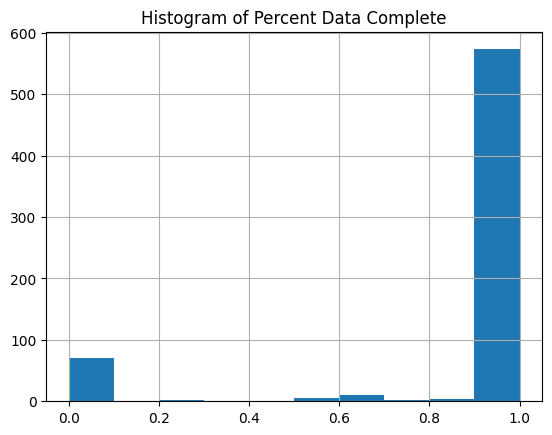

In [11]:
pd.DataFrame([np.count_nonzero(temp[i])/temp.iloc[:,1].size for i in temp.columns]).hist(bins=10)
plt.title("Histogram of Percent Data Complete")

It looks like there are some sparse columns...

Text(0.5, 1.0, 'Boxplot of Percent Data Complete')

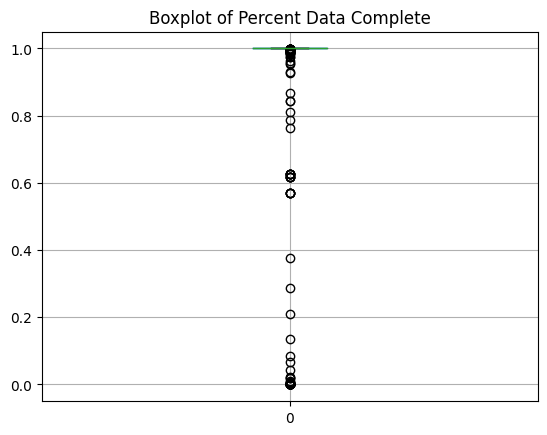

In [12]:
pd.DataFrame([np.count_nonzero(temp[i])/temp.iloc[:,1].size for i in temp.columns]).boxplot()
plt.title("Boxplot of Percent Data Complete")

Definitely less than 25% of them...

What features are they? What are their values?


In [13]:
pd.DataFrame([np.count_nonzero(temp[i])/temp.iloc[:,1].size for i in temp.columns])

,0
0,0.000000
1,0.000218
2,0.000218
3,0.625436
4,1.000000
...,...
665,1.000000
666,1.000000
667,1.000000
668,1.000000


In [14]:
sparse_col_list = []
one_hot_col_list = []
all_zero_list = []
for i in temp.columns:
  if np.count_nonzero(temp[i])/temp.iloc[:,1].size < .1:
    sparse_col_list.append(i)
    if temp[i].value_counts().size == 2:
      one_hot_col_list.append(i)
    if temp[i].value_counts().size == 1:
      all_zero_list.append(i)

print(len(sparse_col_list))
print(len(one_hot_col_list))
print(len(all_zero_list))

#print("here are sparse col names: ", sparse_col_list)
#print("numer of sparse cols: ", len(sparse_col_list))


71
19
48


I'm a little surprised there are 48 features with nothing in them... maybe let's get rid of them? I suppose they could be in the test data, but even so, the model couldn't stand a chance to learn something about them... Let's double check they are in fact all zero

In [15]:
(temp[all_zero_list[:]] == 0).value_counts().value_counts()

,count
count,
4584,1


OK great! We've identified 48 features we can eliminate right off the bat.

In [16]:
feat_engineered_train = pd.DataFrame(train_dt.drop(columns=all_zero_list))

In [17]:
feat_engineered_train.columns.size == train_dt.columns.size - len(all_zero_list)

True

In [18]:
sample_train = sample_train.drop(columns=all_zero_list)
sample_validate = sample_validate.drop(columns=all_zero_list)

**"Bright" Idea 3.5: Check Var Types**

Whooops! Sometimes you forget the obvious. We should check the variable types!

In [19]:
print(sample_train.dtypes)

x2           int64
x3           int64
x4           int64
x5         float64
x6         float64
            ...   
z222       float64
subject     object
phase        int64
state       object
output       int64
Length: 622, dtype: object


In [20]:
sample_train.dtypes.value_counts()

,count
float64,474
int64,146
object,2


In [21]:
object_cols = []
for i in sample_train.columns:
  if sample_train[i].dtype == 'object':
    object_cols.append(i)

print(object_cols)

['subject', 'state']


In [22]:
sample_train[object_cols]

,subject,state
2972,L,B
1615,F,C
1978,I,B
2896,K,B
28,H,C
...,...,...
2129,C,C
3078,I,C
990,A,A
400,I,A


Ah interesting--we can't necessarily assume that these columns are ordinal. That is it's not necessarily true that just because C comes after B in the alphabet that there is some ordered relationship between observations with state C and state B.

If we wanted to play it safe, then, to create a numeric encoding that doesn't assume ordinality, we could create "one hot" encodings.

These one hot encodings basically make it such that each value of the state and subject columns would have its own column which would be a binary indicator variable. For example, all observations would have a column for "B" state and for "B" subject.

But this could create a lot of columns! Let's see how many

In [23]:
values = []
for i in object_cols:
  values.append(sample_train[i].value_counts().size)

print(values)


[11, 4]


That's fifteen columns! Not terrible, but not great. We can actually take a column away from each set to create a reference category and avoid multi-colinearity. This would give us a total of 13 columns.

It's possible that these columns are perfectly correlated so that, for example, subject B always has state A. Let's see if there are redundancies in the combinations of columns

In [24]:
sample_train[object_cols].value_counts().shape

(43,)

Nope! I'd rather have 13 one hot columns than 41!

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
drop_enc = OneHotEncoder().fit(sample_train[object_cols])

In [27]:
drop_enc.categories_

[array(['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'M'],
       dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [28]:
data = drop_enc.transform(sample_train[object_cols]).toarray()

In [29]:
labels = drop_enc.get_feature_names_out()

In [30]:
one_hot_object_cols = pd.DataFrame(data, columns=labels)

In [31]:
print(one_hot_object_cols.index)
print(sample_train.index)

RangeIndex(start=0, stop=500, step=1)
Index([2972, 1615, 1978, 2896,   28,  485, 1973, 1882, 2241,  618,
       ...
       2869, 1457,  751,  456, 3986, 2129, 3078,  990,  400, 1762],
      dtype='int64', length=500)


In [32]:
one_hot_object_cols.index = sample_train.index

In [33]:
print(one_hot_object_cols.index)
print(sample_train.index)

Index([2972, 1615, 1978, 2896,   28,  485, 1973, 1882, 2241,  618,
       ...
       2869, 1457,  751,  456, 3986, 2129, 3078,  990,  400, 1762],
      dtype='int64', length=500)
Index([2972, 1615, 1978, 2896,   28,  485, 1973, 1882, 2241,  618,
       ...
       2869, 1457,  751,  456, 3986, 2129, 3078,  990,  400, 1762],
      dtype='int64', length=500)


In [34]:
temp = pd.concat([sample_train, one_hot_object_cols], axis=1, join="inner")

In [35]:
temp.head(3)

,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,...,subject_G,subject_H,subject_I,subject_K,subject_L,subject_M,state_A,state_B,state_C,state_D
2972,0,0,1,36.705685,0.910160,-5.685750,3.407733,0.007661,-0.000027,0.000010,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1615,0,0,0,-205.885208,1.233226,-2.952087,106.083256,0.022684,0.000044,0.000052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1978,0,0,1,-11.266872,2.659699,-1.688600,9.699462,0.037500,-0.000057,-0.000047,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [36]:
print(temp.shape)
print(sample_train.shape)
print(one_hot_object_cols.shape)

(500, 637)
(500, 622)
(500, 15)


In [37]:
sample_train = temp.drop(columns=object_cols)

In [38]:
print(sample_train.shape)

(500, 635)


Great! We now have our one hot variables. Now let's do the same with the validation data as well.

First let's double check we're dropping the same columns

In [39]:
object_cols = []
for i in sample_validate.columns:
  if sample_validate[i].dtype == 'object':
    object_cols.append(i)

print(object_cols)

['subject', 'state']


Good!

In [40]:
drop_enc = OneHotEncoder().fit(sample_validate[object_cols])
data = drop_enc.transform(sample_validate[object_cols]).toarray()
labels = drop_enc.get_feature_names_out()
one_hot_object_cols = pd.DataFrame(data, columns=labels)
one_hot_object_cols.index = sample_validate.index
temp = pd.concat([sample_validate, one_hot_object_cols], axis=1, join="inner")
sample_validate = temp.drop(columns=object_cols)

In [41]:
print(temp.shape)
print(sample_validate.shape)
print(one_hot_object_cols.shape)

(100, 637)
(100, 635)
(100, 15)


Neat!

**Bright Idea 4: Reduce Dimensionality**

The big idea here is that we want to reduce the dimensionality of the data. We could use PCA to get a list of principal components, and then use a certain subset of principal components to regress the data onto the output class. This would (1) represent the data with fewer dimensions and (2) give us a baseline accuracy.

However, the issue with this is that PCA reduces the dimensionality of the data with respect to the variation rather than with respect to the data's relevance for predicting a certain outcome. That means that using PCR (principal component regression) can sacrifice accuracy.

We can overcome this by keeping the feature-engineered data we have (we deleted some entirely zero columns) and using a model that has a l1 regularization method. L1 regularlization, also known as Lasso, will use ML to find optimal models that reduce some variables' contribution to the model to zero. It's advantageous for us because we can set the amount of regularization to be heavy or light--removing more or less variables. It also is advantageous because this dimension reduction is happening with respect to the outcome, rather than with respect to the variance of the predictor data alone.

For our particular problem, we are going to use multinomial logistic regression because we are trying to classify into multiple discrete bins.

In [42]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [43]:
sample_train_y = np.array(sample_train['output'])
sample_train_x = pd.DataFrame(sample_train.drop(columns='output'))

In [44]:
print(sample_train_y.shape)
print(sample_train_x.shape)
print(sample_train.shape)

(500,)
(500, 634)
(500, 635)


In [45]:
clf = LogisticRegression(penalty = 'l1', C=0.5, random_state=1, solver = 'saga', max_iter = 25).fit(sample_train_x, sample_train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [46]:
clf.score(sample_train_x, sample_train_y)

0.824

Mean accuracy 81% for training seems good--possibly too good e.g. overfitting. How many columns did it need to use? How many did we start with?

In [47]:
col_l1_drop = clf.coef_ != 0

In [48]:
sample_train_x.columns[col_l1_drop[0]].size

279

In [49]:
train_dt.columns.size

670

In [50]:
sample_train_x.columns[col_l1_drop[0]].size/train_dt.columns.size

0.4164179104477612

It returned a model with about 60% of the variables. Neat.

Well, let's see how it does with the validation dataset eh?

In [51]:
sample_validate_y = np.array(sample_validate['output'])
sample_validate_x = pd.DataFrame(sample_validate.drop(columns='output'))

In [52]:
pred = clf.predict(sample_validate_x)

In [53]:
sum(pred == sample_validate_y)/len(pred)

0.83

Well that seems very promising. It got a validated probability of 84% on a sample with only 100 observations!

**# Bright idea 5: run promising model on the full test set**

First, let's train the model on the full training dataset.

In [54]:
train_dt = pd.DataFrame(train_dt.drop(columns=all_zero_list))
drop_enc = OneHotEncoder().fit(train_dt[object_cols])
data = drop_enc.transform(train_dt[object_cols]).toarray()
labels = drop_enc.get_feature_names_out()
one_hot_object_cols = pd.DataFrame(data, columns=labels)
one_hot_object_cols.index = train_dt.index
temp = pd.concat([train_dt, one_hot_object_cols], axis=1, join="inner")
train_dt = temp.drop(columns=object_cols)

Now that we've feature engineered the training data as we did on the sample--let's train the full model.

In [55]:
train_y = np.array(train_dt['output'])
train_x = pd.DataFrame(train_dt.drop(columns='output'))

In [56]:
clf = LogisticRegression(penalty = 'l1', C=0.5, random_state=1, solver = 'saga', max_iter = 25).fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [57]:
clf.score(train_x, train_y)

0.8444589877835951

84% accuracy feels good to me! Let's hope it's not too good to be true...

Let's load the full test dataset and get ready to run it on that.



In [58]:
test_dt = pd.read_csv("test_data.csv")

Let's feature engineer the test dataset as above

In [59]:
test_dt = pd.DataFrame(test_dt.drop(columns=all_zero_list))
test_dt[object_cols]
drop_enc = OneHotEncoder().fit(test_dt[object_cols])
data = drop_enc.transform(test_dt[object_cols]).toarray()
labels = drop_enc.get_feature_names_out()
one_hot_object_cols = pd.DataFrame(data, columns=labels)
one_hot_object_cols.index = test_dt.index
temp = pd.concat([test_dt, one_hot_object_cols], axis=1, join="inner")
test_dt = temp.drop(columns=object_cols)

In [60]:
test_set = set(test_dt.columns)

In [61]:
train_set = set(train_dt.columns)

In [62]:
test_train_diff = test_set - train_set

In [63]:
test_train_diff

{'subject_E', 'subject_J'}

We note that the test set has two subject values that the train set does not. Let's examine the values really quickly.

In [64]:
print(test_dt['subject_E'].value_counts()/len(test_dt))
print(test_dt['subject_J'].value_counts()/len(test_dt))

subject_E
0.0    0.819861
1.0    0.180139
Name: count, dtype: float64
subject_J
0.0    0.636836
1.0    0.363164
Name: count, dtype: float64


We note that a lot of the data in the test set are not from the subjects in the train set--in fact over 50%.

Anticipating this difficulty, we set our one hot encoder to not create a reference group. We note that usually it's good practice to do so--dropping the first group can often mitigate multi-coliniarity that comes from one hot encoding.

However, in this case, it was advantageous to keep all possible subject and states as binary variables. This means, in the training set, that an observation will never have all 0s for its subject or state binary variables. It will always have one feature with a one in it.

This lets us handle this new data in the test set by dropping it. Doing so will make subject E and subject J (when we drop them) a reference category. In the test set, it is fully possible that all subjects could be 0, unlike in the training set. This will let us run the trained algorithm on the test set, without indicating to the trained algorithm that these subject E or subject J rows are part of the trainings reference group (the training set has no reference group).

In [65]:
test_dt = pd.DataFrame(test_dt.drop(list(test_train_diff),axis=1))

Now with our data all set up we run the model.

In [66]:
test_dt.columns

Index(['x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       ...
       'subject_H', 'subject_I', 'subject_K', 'subject_L', 'subject_M',
       'state_A', 'state_B', 'state_C', 'state_D', 'state_E'],
      dtype='object', length=635)

In [67]:
pred = clf.predict(test_dt)

Does this pass the eye test?

In [68]:
pd.DataFrame(pred).value_counts()

,count
0,
1,1717
0,15


While I was hopeful, I am cringing a bit. It seems unlikely to me that it would be so heavily in one class and not another... Well... Let's upload it to kaggle and find out!

In [69]:
output = pd.DataFrame(pred)

In [70]:
output.head()

,0
0,1
1,1
2,1
3,1
4,1


In [71]:
output.to_csv("output.csv",index=True)

**Big Idea 6: the truly naive approach**

After seeing this model crash and burn on the public boards (50% accuracy) it made me wonder--what's the most naive approach I could take?

In [72]:
train_dt['output'].value_counts()/len(train_dt)

,count
output,
1,0.844895
0,0.155105


Well--if I had guessed the training set was all 1s I would be about 84% correct...is that what happened with my predictions?

In [73]:
train_dt_x = pd.DataFrame(train_dt.drop(columns='output'))

In [74]:
pred_train = clf.predict(train_dt_x)

In [75]:
pd.DataFrame(pred_train).value_counts()

,count
0,
1,4576
0,8


Haha! Well would you look at that!

Well, let's use those class notes and try to build a better model! Specifically, by oversampling or undersampling some data.

**Big Idea 7: Overtrain on small data**

Let's fix this by trying to train on a dataset that more evenly represents both classes

In [76]:
train_dt['output'].value_counts()

,count
output,
1,3873
0,711


In [81]:
train_dt_0 = pd.DataFrame(train_dt[train_dt['output']==0])

In [80]:
train_dt_1 = pd.DataFrame(train_dt[train_dt['output']==1].sample(n=700))

In [84]:
train_dt_even = pd.concat([train_dt_0,train_dt_1])

In [86]:
train_y = np.array(train_dt_even['output'])
train_x = pd.DataFrame(train_dt_even.drop(columns='output'))

In [87]:
clf = LogisticRegression(penalty = 'l1', C=0.5, random_state=1, solver = 'saga', max_iter = 25).fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [89]:
clf.score(train_x,train_y)

0.5804394046775336

That's not great--58%--I wonder if we can fix some hyperparameters to improve it. But it's also not horrible!

In [90]:
clf = LogisticRegression(penalty = 'l1', C=0.25, random_state=1, solver = 'saga', max_iter = 25).fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [91]:
clf.score(train_x,train_y)

0.5797306874557052

Still not too great... I wonder if it's doing a better job with one class than the other...

In [92]:
pred = clf.predict(train_x)

In [96]:
pd.crosstab(train_y,pred)/len(train_y)

col_0,0,1
row_0,,
0,0.343728,0.160170
1,0.260099,0.236003


It's not doing as well for 1 as it is for 0. Interesting. I think we had the reverse last time. Let's boost the C...

In [97]:
clf = LogisticRegression(penalty = 'l1', C=0.75, random_state=1, solver = 'saga', max_iter = 25).fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [98]:
clf.score(train_x,train_y)

0.5804394046775336

Not any different at all. Maybe more iterations...

In [99]:
clf = LogisticRegression(penalty = 'l1', C=0.75, random_state=1, solver = 'saga', max_iter = 50).fit(train_x, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [100]:
clf.score(train_x,train_y)

0.5910701630049611

Little bit better, not too much better though...

In [101]:
pd.crosstab(train_y,pred)/len(train_y)

col_0,0,1
row_0,,
0,0.343728,0.160170
1,0.260099,0.236003


Still better for 0 than for 1... Well, let's run it and submit some predictions.

In [105]:
output = pd.DataFrame(clf.predict(test_dt))

In [106]:
output.to_csv("output.csv",index=True)